In [ ]:

#default_exp core-torch

In [2]:
#export
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from skimage.feature import peak_local_max

In [3]:
#export
def expand_dim_to_3(arr):
    if arr.ndim == 2:
        return np.expand_dims(arr, axis=-1)
    elif arr.ndim == 3:
        return arr
    else:
        raise ValueError()

In [4]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')
    plt.axis('off')

torch.Size([3, 128, 192])

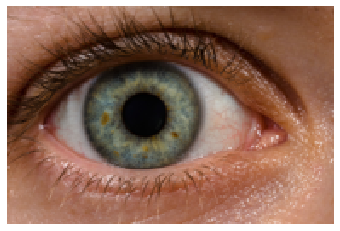

In [55]:
import torch
from PIL import Image
from torchvision.transforms import ToPILImage, ToTensor

img = ToTensor()(Image.open('../images/eye.png').resize((192, 128)))
show(img)

In [7]:
from IPython.display import display
from sympy import symbols, cos, sin, Eq, solve
from sympy.utilities.lambdify import lambdify, implemented_function

sym_x, sym_y, sym_a, sym_b, sym_A = symbols('x y a b A') 
expr = Eq((sym_x * cos(sym_A) + sym_y * sin(sym_A)) ** 2 / sym_a ** 2 + (sym_x * sin(sym_A) + sym_y * cos(sym_A)) ** 2 / sym_b ** 2, 1)
display(expr)

display(solve(expr.subs(sym_y,0), sym_x)[0])

display(solve(expr.subs(sym_x,0), sym_y)[0])

Eq((x*sin(A) + y*cos(A))**2/b**2 + (x*cos(A) + y*sin(A))**2/a**2, 1)

-a*b*sqrt(1/(a**2*sin(A)**2 + b**2*cos(A)**2))

-a*b*sqrt(1/(a**2*cos(A)**2 + b**2*sin(A)**2))

In [8]:
def parametric_ellipse(alpha, A, a, b):
    X = a * np.cos(alpha) * np.cos(A) - b * np.sin(alpha) * np.sin(A)
    Y = a * np.cos(alpha) * np.sin(A) + b * np.sin(alpha) * np.cos(A)
    return X, Y

In [46]:
def elliplise(axes, angle, center=None, width=None, height=None):
    a = axes[0]
    b = axes[1]
    
    A = np.deg2rad(angle)
    cc = [parametric_ellipse(alpha, A, a, b) for alpha in np.linspace(0, np.pi*2, 1000)]

    if height is None and width is None:
        width, height = np.max(cc, axis=0)
        width = round(width) * 2 + 1
        height = round(height) * 2 + 1

    if center is None:
        center = (round(width/2), round(height/2))
    
    mask = np.zeros((height, width), np.uint8) 
    template = torch.Tensor(cv.ellipse(mask, center, axes, angle, color=1, thickness=-1, startAngle=0, endAngle=360)).unsqueeze(0)
    return template

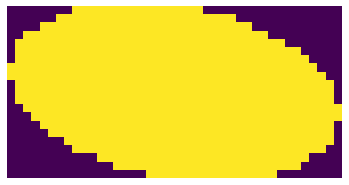

In [50]:
axes_out = (20, 10)
angle = 190

full_region = elliplise(axes_out, angle)
show(full_region)

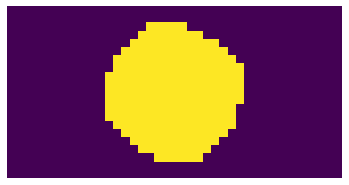

In [51]:
axes_in = (8, 8)
height, width = full_region.shape[1:]
inner_region = elliplise(axes=axes_in, angle=angle, height=height, width=width)
show(inner_region)

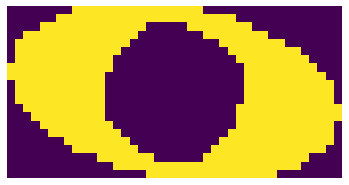

In [53]:
outer_region = full_region - inner_region
show(outer_region)

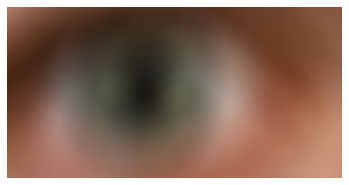

In [325]:
weights = template.repeat([3,1,1,1]) / template.sum()
out = torch.nn.functional.conv2d(img.unsqueeze(0), weights, groups=3)[0]

show(out)

In [29]:
# export

def elliptic_region(img, center, axes=None, angle=0, r=None, as_image=False, crop=False):
    """Returns the pixels in a elliptic region of a given image.
    
    Parameters:
    - img: 
    - center:
    - axes:
    - angle:
    - r:
    - as_image
    - crop
    """
    assert axes is not None or r is not None, "Either axes or radius must be passed"
    
    cx, cy = center
    a, b = axes if r is None else r,r
    
    width = img.shape[0]
    height = img.shape[1]
    mask = np.zeros((width, height), np.uint8) 

    circle_img = cv.ellipse(mask, center, axes, angle, color=(255,255,255), thickness=-1, startAngle=0, endAngle=360)
    
    masked_data = cv.bitwise_and(img, img, mask=circle_img)
    if crop:
        m = max(a,b)//2 #margin
        masked_data = masked_data[cy-m:cy+m+1, cx-m:cx+m+1]
        
    masked_data = expand_dim_to_3(masked_data)
    if as_image:
        return masked_data
    else:
        pixels = masked_data[masked_data.sum(axis=2)!=0]
#         pixels = masked_data[masked_data!=(0,0,0)]
        return pixels 


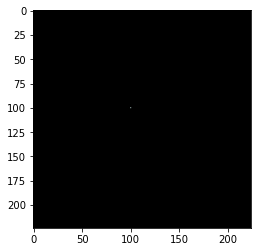

In [35]:
emg = elliptic_region(img, (100,100), axes=None, angle=0, r=30, as_image=True)
plt.imshow(emg)

In [8]:
seperability_filter(img, axes_in=(20,20), axes_out=(30,15), angle=10)

  9%|▊         | 14/164 [00:11<02:00,  1.24it/s]


KeyboardInterrupt: 

In [5]:
#export
def regions(img, center, axes_in, axes_out, angle):
    full_region = elliptic_region(img, center, axes_out, angle=angle, as_image=True)

    blank_img = np.ones(full_region.shape[:2], dtype='uint8') * 255
    mask = elliptic_region(blank_img, center=center, axes=axes_in, as_image=True, angle=angle)

    outer_region = cv.bitwise_and(full_region, full_region.copy(), mask=cv.bitwise_not(mask))
    outer_region = expand_dim_to_3(outer_region)
    outer_region = outer_region[outer_region.sum(axis=2)!=0]
    
    inner_region = elliptic_region(full_region, center=center, axes=axes_in, as_image=False, angle=angle)
    return inner_region, outer_region

In [6]:
#export
def seperability_filter(img, axes_in, axes_out, angle):
    width, height = img.shape[:2]
    result = np.zeros((width, height))
    
    for x in tqdm(range(axes_out[0], width-axes_out[0])):
        for y in range(axes_out[1], height-axes_out[1]):
            
            center = x, y
            r1_pixels, r2_pixels = regions(img, center, axes_in, axes_out, angle)

            
#             r1_pixels = intensity_region_1(img, x, y, r_in, True)
#             r2_pixels = intensity_region_2(img, x, y, r_in, r_out, True)
            if r1_pixels.size==0 or r2_pixels.size==0:
                result[x, y] = 0
                continue
            
            r1_mean = r1_pixels.mean(axis=0, keepdims=True).T
            r2_mean = r2_pixels.mean(axis=0, keepdims=True).T
            
            n_r1 = len(r1_pixels)
            n_r2 = len(r2_pixels)
            
            n_overall = n_r1 + n_r2
            overall_mean = r1_mean * n_r1/n_overall + r2_mean * n_r2/n_overall
                        
            S_B = n_overall * (r1_mean - overall_mean).dot((r1_mean - overall_mean).T) + \
                n_overall * (r2_mean - overall_mean).dot((r2_mean - overall_mean).T)
            
            S_T = np.cov(np.concatenate([r1_pixels, r2_pixels]).T)
            if np.isnan(S_B).any() or np.isnan(S_T).any():
                result[x, y] = 0
            elif S_B.size==1:
                result[x,y] = S_B / S_T
            else:
                result[x,y] = np.trace(S_B) / np.trace(S_T)
                
    return result